In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import librosa
from microphone import record_audio, play_audio
from scipy.ndimage.filters import maximum_filter
from scipy.ndimage.morphology import generate_binary_structure, binary_erosion
from scipy.ndimage.morphology import iterate_structure
from collections import Counter
import pickle

fs = 44100
fss = 44032
song_database = {}
totalMatches_database = {}
songLength_database = {}

In [2]:
asdf = pickle.load( open( "song_database.p", "rb" ) )
totalMatches_database = pickle.load( open( "totalMatches_database.p", "rb" ) )
songLength_database = pickle.load( open( "song_database.p", "rb" ) )


In [4]:
#Convert Input to Array

def file_to_array(file_path):
    """  It transforms a song into a np array
    :param
        file_path[String]:
            A file path to the song
    :return:
        samples[np.array]:
            This is an array of the values of the song at the file path at a sampling rate of 44100 Hz.
    """
    samples, fs = librosa.load(file_path, sr = 44100, mono = True)
    return samples

def mic_to_numpy_array(time):
    mic_input, fs= record_audio(time)
    a = []
    for i in mic_input:
        a.append(np.fromstring(i, dtype=np.int16))
    a = np.hstack(a)
    return a

###Get DATA

def spectogram(samples):
    """
    :param
        samples:
    :return:
        (S, f, t):
            This is a tuple of the spectrogram, the frequencies and the times.
        S:
            The 2D array of the coefficients of the DFT of the song. So S[i, j] is the coefficient at frequency = i
            and time = j.
        f:
    """

    digital = np.copy(samples)
    S, f, t = mlab.specgram(digital, NFFT=4096, Fs=fs, window=mlab.window_hanning, noverlap=(4096 // 2))
    to_return = (S, f, t)
    return to_return

def peaks(spectrogram_arr):
    """
    This finds the peaks of a spectrogram.
    :param:
    spectrogram_arr[np.array]:
    An array of the spectrogram.
    The 2D array of the coefficients of the DFT of the song. So S[i, j] is the coefficient at frequency = freq[i]
    and time = time[j].
    :return:
    peaks[np.array]:
    This is an array with the values of the peaks in the respective
    areas that are there.
    """
    struct = generate_binary_structure(2, 1)
    neighborhood = iterate_structure(struct, 10)

    is_peaks = spectrogram_arr == maximum_filter(spectrogram_arr, footprint=neighborhood)
    ys, xs = np.histogram(spectrogram_arr.flatten(), bins=spectrogram_arr.size // 2, normed=True)
    dx = xs[-1] - xs[-2]
    cdf = np.cumsum(ys) * dx  # this gives you the cumulative distribution of amplitudes
    cutoff = xs[np.searchsorted(cdf, 0.77)]
    foreground = (spectrogram_arr >= cutoff)
    # fig, (ax1, ax2) = plt.subplots(1, 2)
    # ax2.imshow(foreground)
    # ax1.imshow(np.logical_and(foreground, is_peaks))
    return np.logical_and(foreground, is_peaks)


def convertData(b):
    temp = []
    lenn = len(b) - 1

    b = np.array(b).T
    for time, row in enumerate(b):
        for freq, item in enumerate(row):
            if (item):
                temp.append((lenn - freq, time))
                # print((lenn - freq,time))
    # return unzip(np.where(asd))#temp
    return temp





def add_song_to_dict(peaks, songTitle, fan=20):
    """
    adds a song to a databse by anazlyzing the difference in time between the change in frequencies
    song ex:
        keys: (f1,f2,t2-t1), (f1,f3,t3-t1), ... (f1,f(1+freqfan), t(1+freqfan)-t1)
              (f2,f3,t3-t2), (f2,f4,t4-t2), ... (f2,f(2+freqfan), t(2+freqfan)-t2)
              ...

        stored for each key: ("title",diff from t1 to beg of mic audio)
    ------------------------------------------------------------------------------------------------

    paramaters:
        peaks: 2D array of Nx2: List of each song's peaks incuding the (freq and time-stamp)
        songTitle: str of songTitle

    returns:
        adds to dictionary all of the keys and a tuple of (their respective song title, t1)
    """
    # pickling - fast way for python to save dictionaries
    for peakStartIndex in range(len(peaks)):
        referencePeak = peaks[peakStartIndex]
        f1 = referencePeak[0]
        #print(peakStartIndex)
        t1 = referencePeak[1]

        # get the slice of fan:
        if fan > len(peaks[peakStartIndex + 1:]):
            peak_slice = peaks[peakStartIndex + 1:]
        else:
            peak_slice = peaks[peakStartIndex + 1:peakStartIndex + fan]

        for peak in peak_slice:
            # what happens if you reach the end!!!! include if statement
            f2 = peak[0]
            t2 = peak[1]
            # check key
            key = (f1, f2, t2 - t1)
            if not (key in song_database):
                song_database[key] = []

            song_database[key].append((songTitle, t1))
            # include another dict for the a new dict for new song nd compare


def check_database(MicPeaks, lengthOfRecording, fan=20, howManyToCompare=5):
    # !!!!TRY DOING PERCENTAES AND NORMAILIZATION FOR SPED UP SONGS AND HIGHER KEY
    """
        First calculates time differences between peaks of input

        Compares the peak distributions of the Mic input to that of the dictionary
        Calls the keys created by the Mic peaks, and searches the database for matching keys
        Creates a new dictionary and for every match, it will enter the same key and enter the tuple: (Song title, T(song) - T(MicInput))
        Checks the dictionarry with Counter() to fnd the greatest number of standardized matches
    ------------------------------------------------------------------------------------------------

    paramaters:
        MicPeaks: 2D array of Nx2: List of Mic song's peaks incuding the (freq and time-stamp)

    returns:
        New dictionary of common keys, including the tuple mentioned above^
        The greatest number of matching bins using Counter() - possibly include a confidence percentage by ranking greatest retyrns, and checking appropriate confidences
    """
    # 1)
    MicKeyList = []
    for peakStartIndex in range(len(MicPeaks)):
        referencePeak = MicPeaks[peakStartIndex]
        f1 = referencePeak[0]
        t1 = referencePeak[1]

        # get the slice of fan:
        if fan > len(MicPeaks[peakStartIndex + 1:]):
            peak_slice = MicPeaks[peakStartIndex + 1:]
        else:
            peak_slice = MicPeaks[peakStartIndex + 1:peakStartIndex + 1 + fan]

        for peak in peak_slice:
            # what happens if you reach the end!!!! include if statement
            f2 = peak[0]
            t2 = peak[1]
            # check key
            key = (f1, f2, t2 - t1)
            MicKeyList.append(key)


#    MicKeyList = []
#    for peakStartIndex in range(howManyRefPeaks):
#        referencePeak = MicPeaks[peakStartIndex]
#        f1 = referencePeak[0]
#        t1 = referencePeak[1]

        # get the slice of fan:
        
#        peak_slice = MicPeaks[peakStartIndex + 1:]

#        for peak in peak_slice:
            # what happens if you reach the end!!!! include if statement
#            f2 = peak[0]
#            t2 = peak[1]
            # check key
#            key = (f1, f2, t2 - t1)
#            MicKeyList.append(key)











    # 2)

    CommonKeys = []
    # checks for MicKeys in song_database_dict
    #   if there is, record tuple: ("Song Title" of match, T(song) - t1 (aka ref[1]))

    
    #print(MicKeyList)
    for key in MicKeyList:
        #print(key)
        if key in song_database:
            #print(key,song_database[key])
            # Its a match!
            # print(len(song_database[key][0]))


            # if length of song_database[key] > 1, do a loop

            for match in song_database[key]:
                songMatchTitle = match[0]
                songT1Ref = match[1]
                
                CommonKeys.append(songMatchTitle)
                #CommonKeys.append(match)
                
    MatchCount = Counter(CommonKeys)
    
    #print(MatchCount.most_common())
    #print(MatchCount)
    
    
    
    
    
    
    
    #average:    
    #############################
    totalMatches = 0
    PercentDict = {}
    for row in MatchCount.most_common(20):
        if not row[0][0] in PercentDict:
            PercentDict[row[0]] = 0
            
        PercentDict[row[0]] += row[1]
        
        totalMatches += row[1]
    
    #print(PercentDict)
    
    name =  Counter(PercentDict).most_common(1)[0][0]
#how good the #1 match is
    #how many matches / how many peaks in song that should be there are in that __ second interval
    #how many matches / (how many peaks in song / total time of song)* length of recording
    #Confidence1 = Counter(PercentDict).most_common(1)[0][1]/(lengthOfRecording*fss*totalMatches_database[name]/songLength_database[name])
    #print(Confidence1)
    
#how it compares to the match next to it
    #matches of song / matches of next best song
    
    Confidence2 = Counter(PercentDict).most_common(1)[0][1]/Counter(PercentDict).most_common(2)[1][1]
    #print(Confidence2)    
    #print("peaks found:", Counter(PercentDict).most_common(1)[0][1],"/n",'samples:',lengthOfRecording*fss,"/n","total matches:",totalMatches_database[name],'/n',"songLength",songLength_database[name])
    #print(Confidence1*(Confidence2-1))
    
    
    
    
    #############################
    PredictedSong = Counter(PercentDict).most_common(1)[0][0]
    #PercentConfidence = Confidence1 #PercentDict[PredictedSong]/totalMatches
    #PercentConfidence=1+(-0.0341778-0.9054751)/(1+((Confidence1/1.390494)**3)*.267277)
    print(Confidence2)
    PercentConfidence=1+(-0.0341778-0.9054751)/(1+((Confidence2/1.40494)**3)*.267277)
    
    
    
    OtherTopSongs = MatchCount.most_common(howManyToCompare+1)
    temmp = np.array(OtherTopSongs)
    y_pos = range(len(temmp))
    performance = temmp[:,1]
    objects = temmp[:,0]
    
    
    plt.bar(y_pos, performance, align='center', alpha=1)
    plt.xticks(y_pos, objects)
    plt.ylabel('Usage')
    plt.title(MatchCount.most_common(1)[0][0])
    plt.show()
    
    

    if PercentConfidence < .32:
        return "Im not Sure"
    return (PredictedSong, str(PercentConfidence*100) + '%')


def addSong(name, fileAddress):
    temp = file_to_array(fileAddress)
    songLength_database[name] = len(temp)
    
    print(name + " array converted")
    S, f, t = spectogram(temp)
    b = peaks(S)
    print(name + ' peaks gotten')

    peaksd = convertData(b)
    print(name + ' data converted')
    print(len(peaksd))
    totalMatches_database[name] = len(peaksd)
    
    
    
    add_song_to_dict(peaksd, name)
    print(name + ' song added')

#song_database

####

def MicCheck(lengthOfRecording=40):
    MicPeaks = mic_to_numpy_array(lengthOfRecording)
    #print(len(MicPeaks))
    print("Mic reocrded")
    Stemp, f, t = spectogram(MicPeaks)
    MicPeaksTemp = peaks(Stemp)
    print("Mic peaks gotten")
    peaksMicFinal = convertData(MicPeaksTemp)
    print("Mic data converted")
    return check_database(peaksMicFinal,lengthOfRecording)

1.8837209302325582


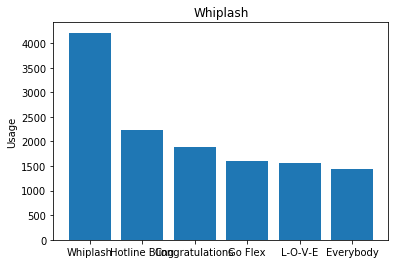

('Whiplash', '42.85133815579729%')

In [620]:
check_database(Whiplash[0:len(Everybody)//4],10)
#lower the recording time
# mess with the peak slice length

#DrakeTest   2.568283594844973e-05     25
#Whiplash    2.6281920738060506e-06    2.6
#Everybody

#FrimFram    8.581851669570777e-07     .8
#SugarHill   5.774140642172362e-07     .5
#44032
#336


In [202]:
pickle.dump( DrakeTest, open( "DrakeTest.p", "wb" ) )
pickle.dump( SugarHill, open("SugarHillTest.p","wb"))
song_database = pickle.load( open( "song_database.p", "rb" ) )

In [ ]:
DrakeTest
SugarHill

In [551]:
len(DrakeTest)

4845

In [5]:
addSong('Moonlight in Vermont',r"/Users/reneegloger/Desktop/Moonlight_in_Vermont.mp3")
addSong('Hotline Bling',r"/Users/reneegloger/Desktop/music/(t)rap/Drake - Hotline Bling.mp3")
addSong("Everybody",r"/Users/reneegloger/Desktop/music/(t)rap/Logic - Everybody (Audio).mp3")
addSong("Go Flex",r"/Users/reneegloger/Desktop/music/(t)rap/Post Malone - Go Flex (Official).mp3")
addSong("Dat $tick",r"/Users/reneegloger/Desktop/music/(t)rap/Rich Chigga - Dat $tick (Official Video).mp3")
#addSong("Black Friday",r"/Users/reneegloger/Desktop/music/(t)rap/Kendrick Lamar  J Cole - Black Friday.mp3")
#addSong("DNA",r"/Users/reneegloger/Desktop/music/(t)rap/Kendrick Lamar - DNA.mp3")
#addSong("iSpy",r"/Users/reneegloger/Desktop/music/(t)rap/KYLE - iSpy (feat. Lil Yachty) [Lyric Video].mp3")
addSong("Congratulations",r"/Users/reneegloger/Desktop/music/(t)rap/Post Malone - Congratulations ft. Quavo.mp3")
#addSong("Frim Fram Sauce",r"/Users/reneegloger/Desktop/music/Jazz/Diana Krall - Frim Fram Sauce.mp3")
addSong("Witchcraft",r"/Users/reneegloger/Desktop/music/Jazz/Frank Sinatra - Witchcraft.mp3")
addSong("Mack the knife",r"/Users/reneegloger/Desktop/music/Jazz/Mack the Knife-Bobby Darin.mp3")
#addSong("Frim Fram Sauce",r"/Users/reneegloger/Desktop/music/Jazz/Diana Krall - Frim Fram Sauce.mp3")
addSong("L-O-V-E",r"/Users/reneegloger/Desktop/music/Jazz/NAT KING COLE  L-O-V-E.mp3")
addSong("Summertime",r"/Users/reneegloger/Desktop/music/Jazz/Summertime.mp3")
addSong("Whiplash",r"/Users/reneegloger/Desktop/music/Jazz/Whiplash - Overture.mp3")

Moonlight in Vermont array converted
Moonlight in Vermont peaks gotten
Moonlight in Vermont data converted
15740
Moonlight in Vermont song added
Hotline Bling array converted
Hotline Bling peaks gotten
Hotline Bling data converted
20634
Hotline Bling song added
Everybody array converted
Everybody peaks gotten
Everybody data converted
13230
Everybody song added
Go Flex array converted
Go Flex peaks gotten
Go Flex data converted
14166
Go Flex song added
Dat $tick array converted
Dat $tick peaks gotten
Dat $tick data converted
10577
Dat $tick song added
Congratulations array converted
Congratulations peaks gotten
Congratulations data converted
16487
Congratulations song added
Witchcraft array converted
Witchcraft peaks gotten
Witchcraft data converted
10760
Witchcraft song added
Mack the knife array converted
Mack the knife peaks gotten
Mack the knife data converted
14570
Mack the knife song added
L-O-V-E array converted
L-O-V-E peaks gotten
L-O-V-E data converted
12576
L-O-V-E song added

In [6]:
song_database == asdf

True

In [655]:
#favorite_color = { "lion": "yellow", "kitty": "red" }
pickle.dump( song_database, open( "song_database.p", "wb" ) )

In [656]:
pickle.dump( totalMatches_database, open("totalMatches_database.p", "wb"))
pickle.dump( songLength_database, open("songLength_database.p", "wb"))



In [ ]:
#songLength_database, totalMatches_database, song_database = pickle.load( open( "save.p", "rb" ) )

In [623]:
int(5.5)

5

In [43]:
MicPeaks = mic_to_numpy_array(8)
print("Mic reocrded")
print(len(MicPeaks))
Stemp, f, t = spectogram(MicPeaks)
MicPeaksTemp = peaks(Stemp)
print("Mic peaks gotten")
peaksMicFinal = convertData(MicPeaksTemp)
print("Mic data converted")
#check_database(peaksMicFinal,40)
Whiplash = peaksMicFinal

Using input device 'Built-in Microphone'
Recording ended
Mic reocrded
352256
Mic peaks gotten
Mic data converted


4.611916264090177


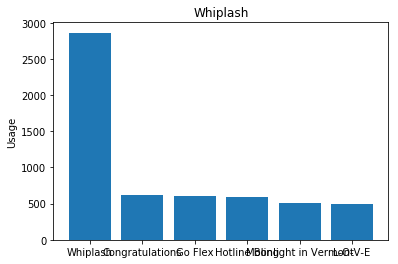

('Whiplash', '91.01186304995052%')

In [44]:
check_database(Whiplash,8)


In [36]:
len(FrimFram)

NameError: name 'FrimFram' is not defined

In [237]:
len(DrakeTest)

4845

In [7]:
a = {(1,0):[('w',1),('d',43)],(34,1):[('r',65),('t',2)]}
pickle.dump( a, open("a.p","wb"))
asd = pickle.load( open( "a.p", "rb" ) )
asdf == a

False

In [12]:
for i in asdf:
    if not asdf[i]==song_database[i]:
        print(i,"\n")

In [18]:
storage = song_database
song_database = asdf

In [75]:
ATIS = "KJFK 040051Z 17009KT 10SM FEW040 BKN110 BKN210 BKN250 25/22 A3009 RMK AO2 RAB15E26 SLP190 OCNL LTGIC DSNT W CB DSNT W P0000 T02500217"

ATIS = ATIS[:ATIS.find("RMK")-1]
def split(string):
    temp = ''
    for num in string:
        temp += num + ' '

    return temp

ATIS = ATIS.split(' ')
for i in range(len(ATIS)):
    if i == 0:
        ATIS[i] = (split(ATIS[i]))
    elif i == 1:
        ATIS[i] = ". "+ split(ATIS[i][2:6])+ ' zulu. '
    elif i == 2:
        ATIS[i] = ATIS[i][:3] +" at "+ ATIS[i][3:5] + " knots. "
    elif i == 3:
        ATIS[i] = "visibility, " + ATIS[i][:2] + " statute miles."
    elif i == len(ATIS)-2:
        ATIS[i] = "tempurature " + ATIS[i][:2] + ", dew point " + ATIS[i][3:] + "."
    elif i == len(ATIS)-1:
        ATIS[i] = " altimeter "+ split(ATIS[i][1:])
    else:
        if temp == 'FEW':
            temp = 'few'
        elif temp == 'SCT':
            temp = 'scattered'
        elif temp == 'CLR':
            temp = 'clear'
        elif temp == 'OVC':
            temp = 'overcast'
        else:
            temp = 'broken'
        ATIS[i] = temp  +ATIS[i][3:] + " "

temp = ""

for item in ATIS:
    temp += item
    
temp

'K J F K . 0 0 5 1  zulu. 170 at 09 knots. visibility 10 statute miles.broken040 broken110 broken210 broken250 tempurature 25, dew point 22. altimeter 3 0 0 9 '

In [54]:
ATIS

['KJFK',
 '040051Z',
 '17009KT',
 '10SM',
 'FEW040',
 'BKN110',
 'BKN210',
 'BKN250',
 '25/22',
 'A3009']